In [0]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.externals.joblib import parallel_backend
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [0]:
data = pd.read_csv("US_Accidents_Dec19.csv")
data.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,I-75 S,R,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


In [0]:
data.columns

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

## Plotting correlation matrix

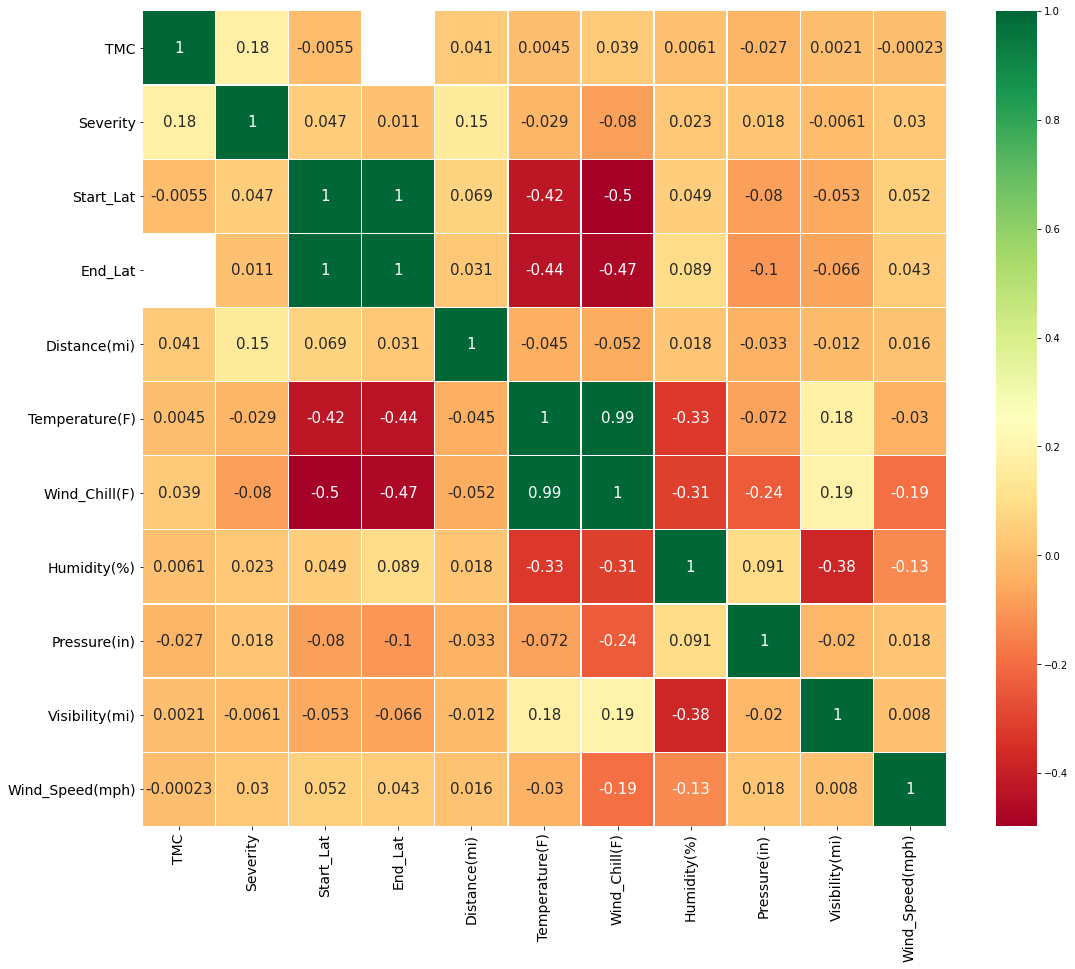

In [0]:
fig=sns.heatmap(data[['TMC','Severity','Start_Lat','End_Lat','Distance(mi)','Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)']].corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':15})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

We can use this to remove highly correlated features like keeping only one of wind chill and temperature as they both mean almost the same thing.

In [0]:
data.columns

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [0]:
data[data.columns[1:]].corr()['Severity'][:]

TMC                  0.177739
Severity             1.000000
Start_Lat            0.047138
Start_Lng            0.055198
End_Lat              0.011288
End_Lng              0.264103
Distance(mi)         0.146393
Number               0.023979
Temperature(F)      -0.029132
Wind_Chill(F)       -0.079993
Humidity(%)          0.023188
Pressure(in)         0.018289
Visibility(mi)      -0.006136
Wind_Speed(mph)      0.030343
Precipitation(in)    0.016632
Amenity             -0.049221
Bump                -0.005455
Crossing            -0.129030
Give_Way            -0.007847
Junction             0.063437
No_Exit             -0.006709
Railway             -0.023666
Roundabout          -0.003843
Station             -0.052094
Stop                -0.055394
Traffic_Calming     -0.006786
Traffic_Signal      -0.195834
Turning_Loop              NaN
Name: Severity, dtype: float64

In [0]:
data.describe()

,TMC,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,2.246264e+06,2.974335e+06,2.974335e+06,2.974335e+06,728071.000000,728071.000000,2.974335e+06,1.056730e+06,2.918272e+06,1.121712e+06,2.915162e+06,2.926193e+06,2.908644e+06,2.533495e+06,975977.000000
mean,2.078316e+02,2.360190e+00,3.649361e+01,-9.542625e+01,37.580871,-99.976032,2.855654e-01,5.837004e+03,6.235120e+01,5.132685e+01,6.540542e+01,2.983190e+01,9.150770e+00,8.298064e+00,0.020495
std,2.032959e+01,5.414733e-01,4.918849e+00,1.721881e+01,5.004757,18.416647,1.548392e+00,1.515928e+04,1.878855e+01,2.519127e+01,2.255676e+01,7.213808e-01,2.892114e+00,5.138546e+00,0.235770
min,2.000000e+02,1.000000e+00,2.455527e+01,-1.246238e+02,24.570110,-124.497829,0.000000e+00,0.000000e+00,-7.780000e+01,-6.590000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,2.010000e+02,2.000000e+00,3.355040e+01,-1.172920e+02,33.957554,-118.286610,0.000000e+00,8.370000e+02,5.000000e+01,3.200000e+01,4.900000e+01,2.982000e+01,1.000000e+01,4.600000e+00,0.000000
50%,2.010000e+02,2.000000e+00,3.584969e+01,-9.025083e+01,37.903670,-96.631690,0.000000e+00,2.717000e+03,6.440000e+01,5.400000e+01,6.700000e+01,2.998000e+01,1.000000e+01,7.000000e+00,0.000000
75%,2.010000e+02,3.000000e+00,4.037026e+01,-8.091891e+01,41.372630,-82.323850,1.000000e-02,7.000000e+03,7.600000e+01,7.300000e+01,8.400000e+01,3.011000e+01,1.000000e+01,1.040000e+01,0.000000
max,4.060000e+02,4.000000e+00,4.900220e+01,-6.711317e+01,49.075000,-67.109242,3.336300e+02,9.999997e+06,1.706000e+02,1.150000e+02,1.000000e+02,3.304000e+01,1.400000e+02,8.228000e+02,25.000000


## Converting time data into seperate columns

In [0]:
data['acc_year'] = pd.to_datetime(data['Start_Time']).dt.year
data['acc_month'] = pd.to_datetime(data['Start_Time']).dt.month
data['acc_hr_day'] = pd.to_datetime(data['Start_Time']).dt.hour

In [0]:
data['new_date'] = pd.to_datetime(data['Start_Time']).dt.date

## Seeing the trends of accidents over the years

In [0]:
temp = data.groupby('new_date')['ID'].count().reset_index()
fig = go.Figure()
fig.add_trace(go.Scatter(x=temp['new_date'], y=temp['ID']))

fig.update_layout(title_text='Accidents trend over the year',xaxis_rangeslider_visible=True)
fig.show()

We can see tha the number of accidents each year is increasing every subsequent year.

In [0]:
data['day_name'] = pd.to_datetime(data['Start_Time']).dt.day_name()

## Seeing which counties have the highest number of accidents

In [0]:
data.groupby('County')['ID'].count().reset_index(name = 'count').sort_values(by = 'count', ascending = False)

,County,count
905,Los Angeles,227180
677,Harris,99134
1139,Orange,75970
996,Mecklenburg,72762
405,Dallas,68558
...,...,...
665,Hand,1
561,Frontier,1
178,Brewster,1
1545,Towns,1


We can see that Los Angeles has the highest number of accidents and by a great margin.

## Getting mean weather conditions for the counties with top accident counts

In [0]:
temp = data.groupby('County')['ID', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)'].agg({'ID':'count', 'Temperature(F)':'mean', 'Wind_Chill(F)':'mean', 'Humidity(%)':'mean', 'Pressure(in)':'mean',
       'Visibility(mi)':'mean', 'Wind_Speed(mph)':'mean',
       'Precipitation(in)':'mean'}).reset_index().sort_values(by = 'ID', ascending = False)

In [0]:
temp[temp['ID']>20000].head(20)

,County,ID,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
905,Los Angeles,227180,67.729334,67.478398,57.676907,29.836423,9.211479,6.568495,0.007968
677,Harris,99134,72.627457,68.855659,68.200386,30.018720,8.981862,9.005016,0.021228
1139,Orange,75970,70.620944,68.897466,65.539316,29.984965,9.430052,7.585831,0.017719
996,Mecklenburg,72762,64.208825,57.846502,65.701423,29.905751,9.033170,7.277891,0.016839
405,Dallas,68558,68.785531,58.264125,63.766231,29.904492,9.412007,9.631917,0.019575
1548,Travis,63603,72.637585,68.758549,62.920900,29.870730,9.205800,7.255371,0.016618
1044,Montgomery,57256,57.681094,42.871086,70.567735,29.986849,8.892551,7.653975,0.016123
1608,Wake,52640,62.995927,54.466333,68.316021,29.984355,9.126542,7.498931,0.017532
944,Maricopa,45524,76.749417,78.131532,31.678340,29.501368,11.223967,7.125621,0.002768
11,Alameda,45367,61.050663,60.325116,66.452078,29.981817,9.367550,8.937369,0.009722


## Checking the distribution of accident severity

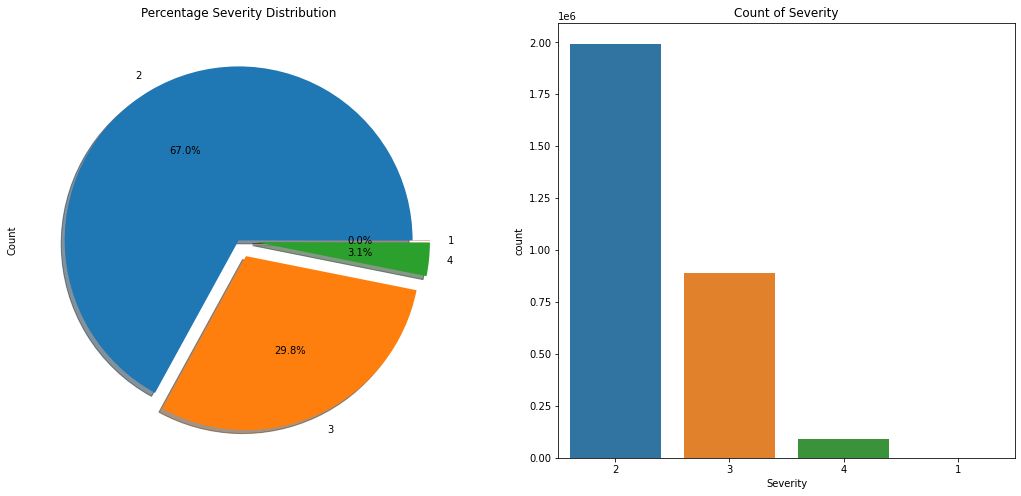

In [0]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Severity'].value_counts().plot.pie(explode=[0,0.1,0.1,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Percentage Severity Distribution')
ax[0].set_ylabel('Count')
sns.countplot('Severity',data=data,ax=ax[1],order=data['Severity'].value_counts().index)
ax[1].set_title('Count of Severity')
plt.show()

More than two-thirds of all accidents that take place have severity of 2.

## Checking the number of accidents per state

Text(0, 0.5, '')

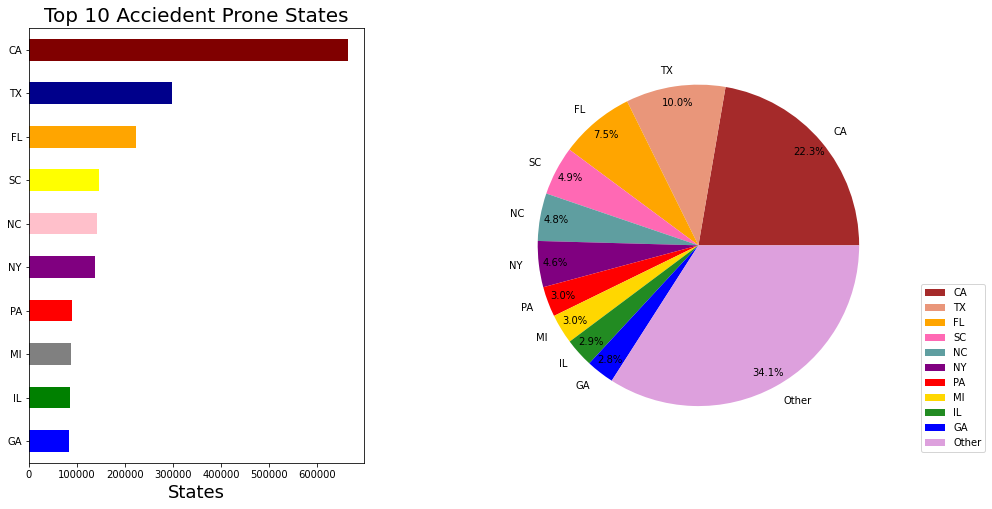

In [0]:
fig,ax=plt.subplots(1,2,figsize=(15,8))
clr = ("blue", "green", "grey", "red", "purple",'pink','yellow','orange','darkblue','maroon')
data.State.value_counts().sort_values(ascending=False)[:10].sort_values().plot(kind='barh',color=clr,ax=ax[0])
ax[0].set_title("Top 10 Acciedent Prone States",size=20)
ax[0].set_xlabel('States',size=18)


count=data['State'].value_counts()
groups=list(data['State'].value_counts().index)[:10]
counts=list(count[:10])
counts.append(count.agg(sum)-count[:10].agg('sum'))
groups.append('Other')
type_dict=pd.DataFrame({"group":groups,"counts":counts})
clr1=('brown','darksalmon','orange','hotpink','cadetblue','purple','red','gold','forestgreen','blue','plum')
qx = type_dict.plot(kind='pie', y='counts', labels=groups,colors=clr1,autopct='%1.1f%%', pctdistance=0.9, radius=1.2,ax=ax[1])
plt.legend(loc=0, bbox_to_anchor=(1.15,0.4)) 
plt.subplots_adjust(wspace =0.5, hspace =0)
plt.ioff()
plt.ylabel('')

As expected, we can see that california has the highest number of accidents followed by texas and florida. This is in line with seeing most accidents in LA as LA is a county in california.

## Checking the weather conditions are most common

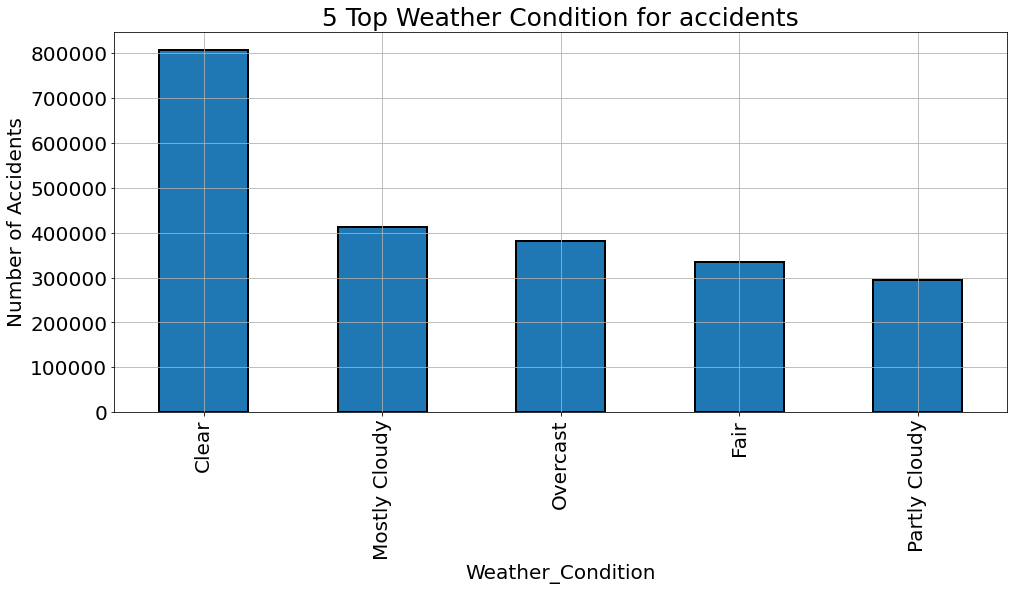

In [0]:
fig, ax=plt.subplots(figsize=(16,7))
data['Weather_Condition'].value_counts().sort_values(ascending=False).head(5).plot.bar(width=0.5,edgecolor='k',align='center',linewidth=2)
plt.xlabel('Weather_Condition',fontsize=20)
plt.ylabel('Number of Accidents',fontsize=20)
ax.tick_params(labelsize=20)
plt.title('5 Top Weather Condition for accidents',fontsize=25)
plt.grid()
plt.ioff()

We can see the most accidents occur when the weather is clear. This might be because having rainfall or cloudy weather is much less common than a clear weather.

# Exploring the target feature which is severity

## At what time are the accidents most common along with severity

In [0]:
hours = list(set(pd.to_datetime(data['Start_Time']).dt.hour))
severity_1_hours = []
severity_2_hours = []
severity_3_hours = []
severity_4_hours = []
for i in hours:
    severity_1_hours.append(data[(data['Severity']==1)&(data['acc_hr_day']==i)].count()['ID'])
    severity_2_hours.append(data[(data['Severity']==2)&(data['acc_hr_day']==i)].count()['ID'])
    severity_3_hours.append(data[(data['Severity']==3)&(data['acc_hr_day']==i)].count()['ID'])
    severity_4_hours.append(data[(data['Severity']==4)&(data['acc_hr_day']==i)].count()['ID'])

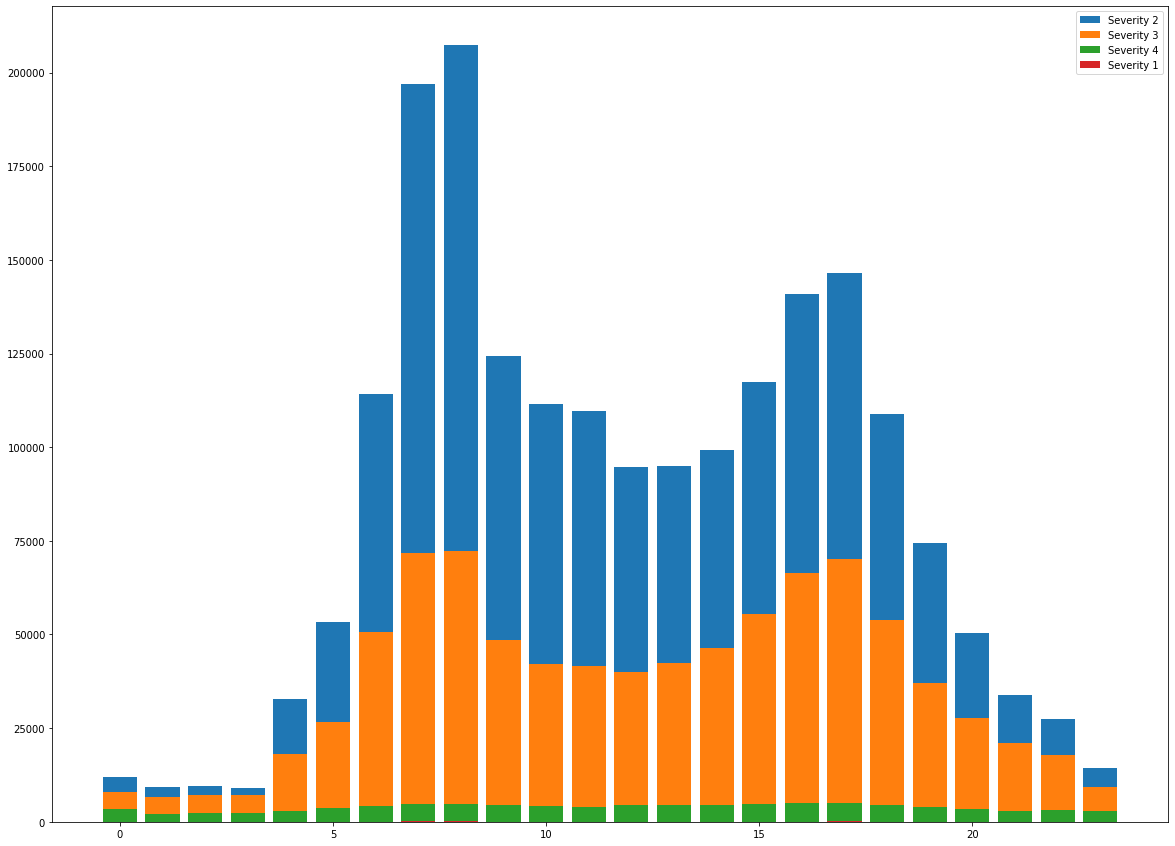

In [0]:
plt.figure(figsize=(20,15))

plt.bar(hours, severity_2_hours, label='Severity 2')
plt.bar(hours, severity_3_hours, label='Severity 3')
plt.bar(hours, severity_4_hours, label='Severity 4')
plt.bar(hours, severity_1_hours, label='Severity 1')


plt.legend()

We can see that the most accidents occur at around 8-9 am in the morning and then there is a second surge at 4 to 5 pm. We know that this is the time when most people travel to and from work, which results in increasing the traffic density which in turn leads to more accidents.

We can also note that as the day goes on, starting from evening time, the percentage of higher severity accidents also increases substantially. It can be concluded with this that as the sun goes down, the accidents are much more drastic even though the overall number of accidents decreases.

## Severity with state

In [0]:
states = data.State.unique()

In [0]:
count_by_state=[]
for i in data.State.unique():
    count_by_state.append(data[data['State']==i].count()['ID'])

In [0]:
severity_1_state = []
severity_2_state = []
severity_3_state = []
severity_4_state = []
for i in states:
    severity_1_state.append(data[(data['Severity']==1)&(data['State']==i)].count()['ID'])
    severity_2_state.append(data[(data['Severity']==2)&(data['State']==i)].count()['ID'])
    severity_3_state.append(data[(data['Severity']==3)&(data['State']==i)].count()['ID'])
    severity_4_state.append(data[(data['Severity']==4)&(data['State']==i)].count()['ID'])

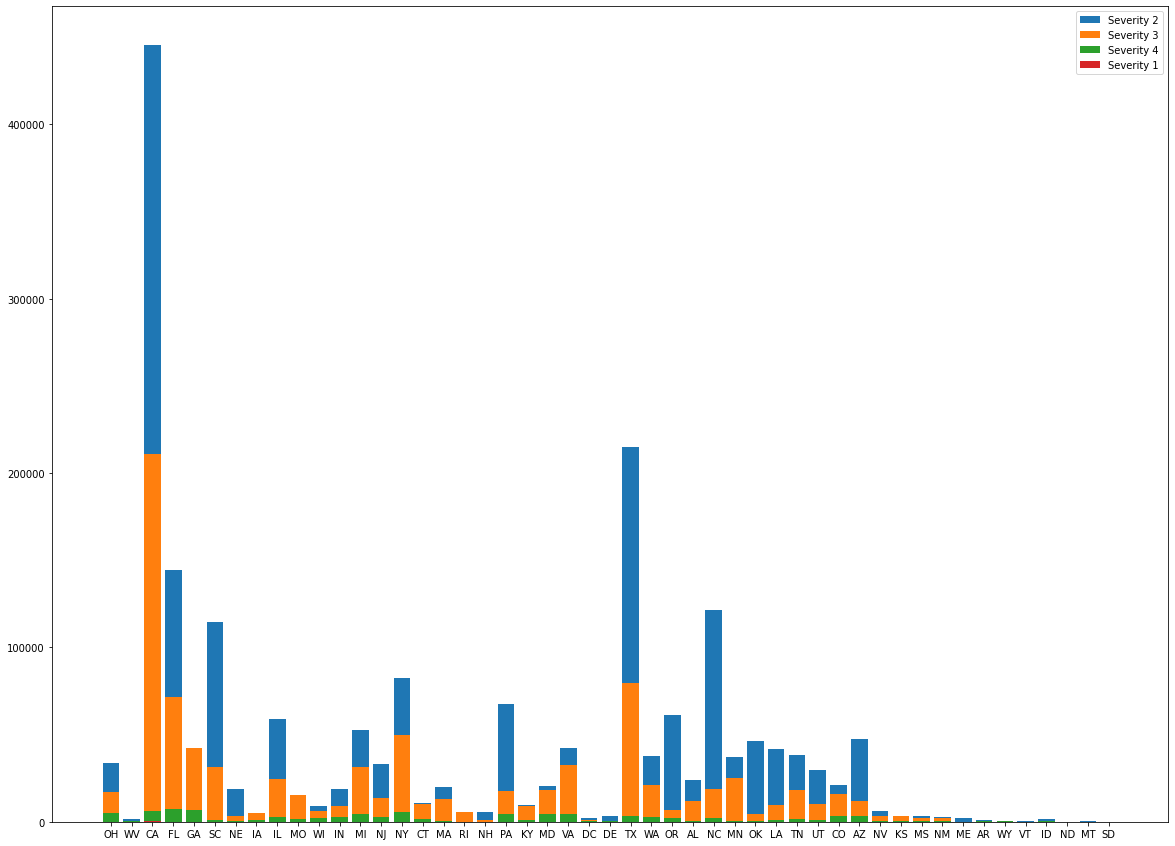

In [0]:
plt.figure(figsize=(20,15))

plt.bar(states, severity_2_state, label='Severity 2')
plt.bar(states, severity_3_state, label='Severity 3')
plt.bar(states, severity_4_state, label='Severity 4')
plt.bar(states, severity_1_state, label='Severity 1')


plt.legend()

In almost all of the states, accidents of severity 2 are the highest followed by severity 3

## Severity with temperature

In [0]:
Temperature = data['Temperature(F)']
severity_1_data = data[data['Severity']==1]['Temperature(F)'].mean()
severity_2_data = data[data['Severity']==2]['Temperature(F)'].mean()
severity_3_data = data[data['Severity']==3]['Temperature(F)'].mean()
severity_4_data = data[data['Severity']==4]['Temperature(F)'].mean()
severity_labels = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']

Mean_temp_by_severity = [severity_1_data, severity_2_data, severity_3_data, severity_4_data]

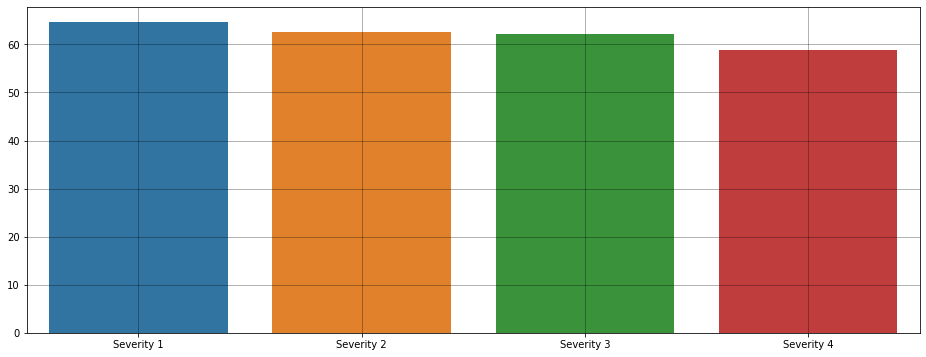

In [0]:
plt.figure(figsize=(16, 6))
sns.barplot(severity_labels, Mean_temp_by_severity)
plt.grid(color='black', linestyle='-', linewidth=1, alpha=0.3)

Higher severity accidents have a lower mean temperature which implies that serious accidents occur more frequently when the temperature is lower.

## Severity with weather

In [0]:
Weather = data.Weather_Condition.value_counts()

In [0]:
severity_1_Weather = []
severity_2_Weather = []
severity_3_Weather = []
severity_4_Weather = []
for i in Weather.index:
    severity_1_Weather.append(data[(data['Severity']==1)&(data['Weather_Condition']==i)].count()['ID'])
    severity_2_Weather.append(data[(data['Severity']==2)&(data['Weather_Condition']==i)].count()['ID'])
    severity_3_Weather.append(data[(data['Severity']==3)&(data['Weather_Condition']==i)].count()['ID'])
    severity_4_Weather.append(data[(data['Severity']==4)&(data['Weather_Condition']==i)].count()['ID'])

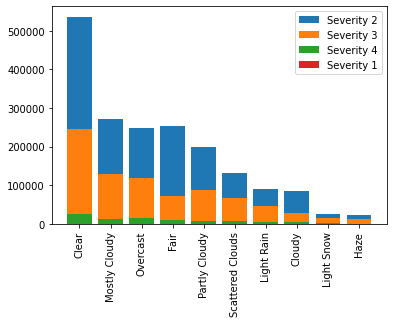

In [0]:
plt.figure()
plt.xticks(rotation=90)
plt.bar(Weather.index[:10], severity_2_Weather[:10], label='Severity 2')
plt.bar(Weather.index[:10], severity_3_Weather[:10], label='Severity 3')
plt.bar(Weather.index[:10], severity_4_Weather[:10], label='Severity 4')
plt.bar(Weather.index[:10], severity_1_Weather[:10], label='Severity 1')
plt.legend()

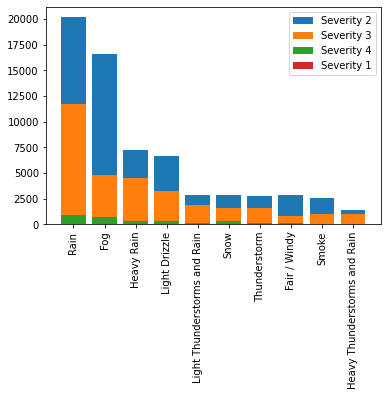

In [0]:
plt.figure()
plt.xticks(rotation=90)
plt.bar(Weather.index[10:20], severity_2_Weather[10:20], label='Severity 2')
plt.bar(Weather.index[10:20], severity_3_Weather[10:20], label='Severity 3')
plt.bar(Weather.index[10:20], severity_4_Weather[10:20], label='Severity 4')
plt.bar(Weather.index[10:20], severity_1_Weather[10:20], label='Severity 1')
plt.legend()

We can see that the fraction of higher severity accidents, get greater when the weather conditions become worse.

In [0]:
percentage_severity_1 = []
percentage_severity_2 = []
percentage_severity_3 = []
percentage_severity_4 = []
for i in range(len(severity_1_Weather)):
    percentage_severity_1.append((severity_1_Weather[i]/Weather[i])*100)
    percentage_severity_2.append((severity_2_Weather[i]/Weather[i])*100)
    percentage_severity_3.append((severity_3_Weather[i]/Weather[i])*100)
    percentage_severity_4.append((severity_4_Weather[i]/Weather[i])*100)

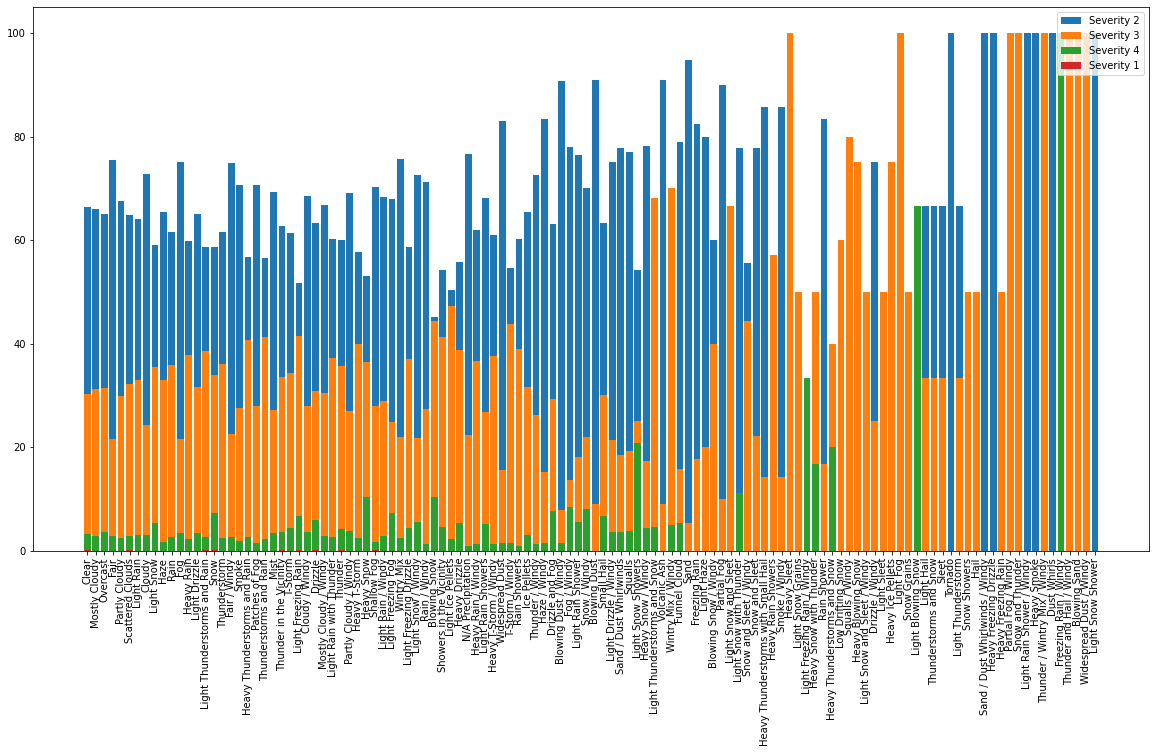

In [0]:
plt.figure(figsize=(20,10))
plt.xticks(fontsize=10, rotation=90)
plt.bar(Weather.index, percentage_severity_2, label='Severity 2')
plt.bar(Weather.index, percentage_severity_3, label='Severity 3')
plt.bar(Weather.index, percentage_severity_4, label='Severity 4')
plt.bar(Weather.index, percentage_severity_1, label='Severity 1')
plt.legend(loc=1, prop={'size': 10})

Here we can note that extreme weather conditions such Heavy thunderstorms, snow pellets, fog, windy etc. have a very high severity of accidents as compared to relatively normal conditions.

## New Features

In [0]:
feature_lst=['Source','TMC','Severity','Start_Lng','Start_Lat',\
             'Distance(mi)','Side','City','County','State','Timezone',\
             'Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)',\
             'Wind_Direction','Weather_Condition','Amenity','Bump','Crossing',\
             'Give_Way','Junction','No_Exit','Railway','Roundabout','Station',\
             'Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset',\
             'Start_Time','Hour','Weekday', 'Duration',\
             'Year','Month']

In [0]:
#duration feature using start and end time
data['Start_Time'] = pd.to_datetime(data['Start_Time'], errors='coerce')
data['End_Time'] = pd.to_datetime(data['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
data['Year']=data['Start_Time'].dt.year
data['Month']=data['Start_Time'].dt.month
#data['Day']=data['Start_Time'].dt.day
data['Hour']=data['Start_Time'].dt.hour
data['Weekday']=data['Start_Time'].dt.strftime('%a')
# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
data['Duration']=round((data['End_Time']-data['Start_Time'])/np.timedelta64(1,'m'))

In [0]:
df = data[feature_lst].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2974335 entries, 0 to 2974334
Data columns (total 37 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Source             object        
 1   TMC                float64       
 2   Severity           int64         
 3   Start_Lng          float64       
 4   Start_Lat          float64       
 5   Distance(mi)       float64       
 6   Side               object        
 7   City               object        
 8   County             object        
 9   State              object        
 10  Timezone           object        
 11  Temperature(F)     float64       
 12  Humidity(%)        float64       
 13  Pressure(in)       float64       
 14  Visibility(mi)     float64       
 15  Wind_Direction     object        
 16  Weather_Condition  object        
 17  Amenity            bool          
 18  Bump               bool          
 19  Crossing           bool          
 20  Give_Way           bool 

In [0]:
# removing duration values which are negative
neg_outliers=df['Duration']<=0
# Set outliers to NAN
df[neg_outliers] = np.nan
# Drop rows with negative duration
df.dropna(subset=['Duration'],axis=0,inplace=True)

In [0]:
# hour of day feature using start time
df['Hour'] = df['Start_Time'].apply(lambda x: pd.to_datetime(x).hour)

In [0]:
#removing features where number of null values>20% of entire values
df = df[df.columns[df.isnull().mean() < 0.2]]

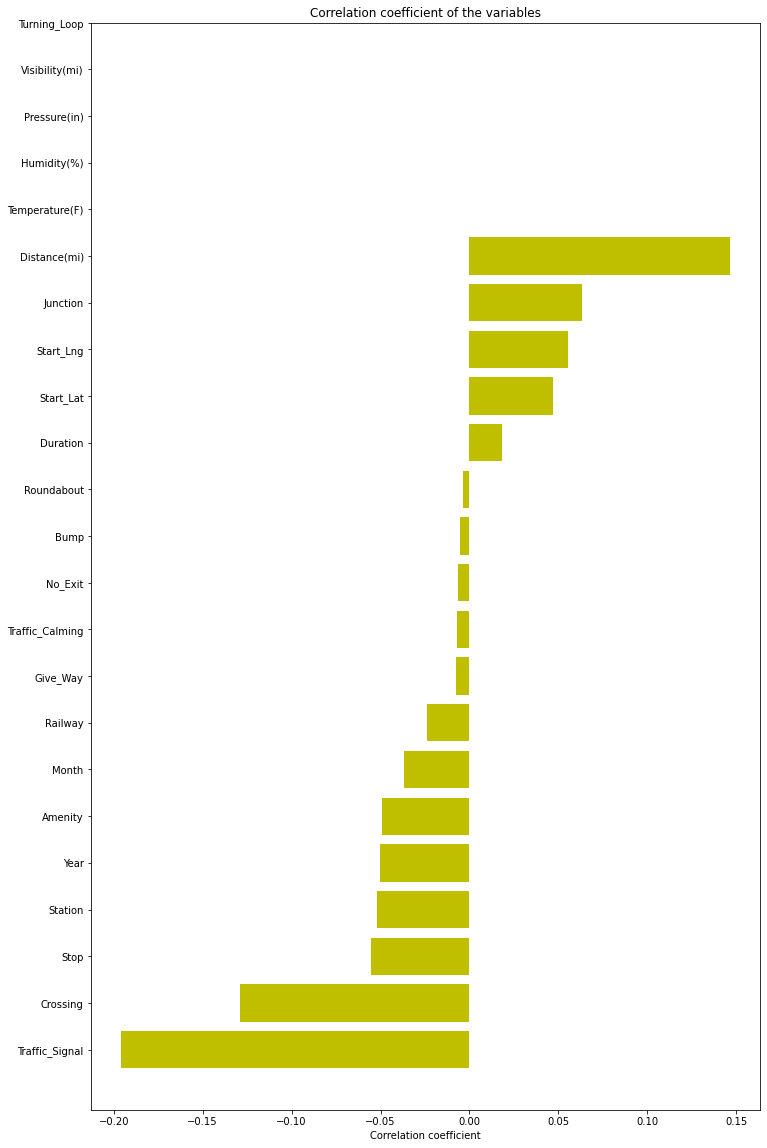

In [0]:
#correlation of columns with severity
x_cols = [col for col in df.columns if col not in ['Severity'] if df[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df.Severity.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,20))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

In [0]:
## dropping some more irrelevant columns
df = df.drop(['Source','Start_Time'],axis=1)

In [0]:
# removing points not lying inside USA coordinates
df = df[((df.Start_Lng >= -161.75583) & (df.Start_Lat >= 19.50139)& \
                   (df.Start_Lng <= -68.01197) & (df.Start_Lat <= 64.85694))]

In [0]:
df['Sunrise_Sunset'].fillna('Day',inplace=True)
df['Weather_Condition'].fillna('Clear',inplace=True)
df['Temperature(F)'].fillna(df['Temperature(F)'].mean(),inplace=True)
df['Humidity(%)'].fillna(df['Humidity(%)'].mean(),inplace=True)
df['Pressure(in)'].fillna(df['Pressure(in)'].mean(),inplace=True)
df['Visibility(mi)'].fillna(df['Visibility(mi)'].mean(),inplace=True)

In [0]:
# getting all the points only in the year 2019 and also adding all points with severity 1 regardless of the year as they are 
# very rare and we need them to train the model
#X_first = df.copy()[df['Year']==2019].drop('Year',axis=1)
#X_second = df.copy()[df['Severity']==1.0].drop('Year',axis=1)
#y_first=X_first['Severity']
#y_second = X_second['Severity']
#X = X_first.append(X_second)
#y = y_first.append(y_second)

In [0]:
X = df.drop('Severity',axis=1)
y = df['Severity']

In [0]:
#encoding weekday
day_dict = {'Sun':0,'Mon':1,'Tue':2,'Wed':3,'Thu':4,'Fri':5,'Sat':6}
X['Weekday'] = X['Weekday'].apply(lambda x: day_dict[x])

In [0]:
# encoding cyclic features
def encode_cyclic(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data.drop(col,axis=1)

X = encode_cyclic(X, 'Weekday', 7)

X = encode_cyclic(X, 'Month', 12)

X = encode_cyclic(X, 'Hour', 24)

In [0]:
from sklearn.cluster import MiniBatchKMeans
# this lib is used while we calculate the stight line distance between two (lat,lon) pairs in miles
import gpxpy.geo #Get the haversine distance

coords = X[['Start_Lng', 'Start_Lat']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")


def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    X['Cluster'] = kmeans.predict(X[['Start_Lng', 'Start_Lat']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

In [0]:
#for increment in range(100, 1500, 100):
#    cluster_centers, cluster_len = find_clusters(increment)
#    find_min_distance(cluster_centers, cluster_len)      

In [0]:
cluster_centers, cluster_len = find_clusters(1100)

In [0]:
# extracting x, y and z from lat and long
X['loc_x'] = np.cos(X['Start_Lat']) * np.cos(X['Start_Lng'])
X['loc_y'] = np.cos(X['Start_Lat']) * np.sin(X['Start_Lng'])
X['loc_z'] = np.sin(X['Start_Lat'])

In [0]:
#filling some remaining nan values with most common value
X['Sunrise_Sunset'].fillna('Day',inplace=True)
X['Weather_Condition'].fillna('Clear',inplace=True)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

# Trying some feature encoding techniques

## Response Coding

In [0]:
# response coding the data
def get_gv_fea_dict(alpha, feature, dataframe):
    
    value_count = dataframe[feature].value_counts()
    gv_dict = dict()
    for i, denominator in tqdm(value_count.items()):
        vec = []
        for k in range(0,4):
            cls_cnt = dataframe.loc[(dataframe['Severity']==k) & (dataframe[feature]==i)]
            vec.append((cls_cnt.shape[0]+alpha)/ (denominator+alpha*2))
        gv_dict[i]=vec
    return gv_dict

def get_gv_feature(alpha, feature, dataframe):
    gv_dict = get_gv_fea_dict(alpha, feature, dataframe)
    value_count = dataframe[feature].value_counts()    
    gv_fea = []
    print(gv_fea)
    for index, row in tqdm(dataframe.iterrows()):
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/4,1/4,1/4,1/4])
    return gv_fea

In [0]:
# loading response coding file
X_train_response = pd.read_pickle('X_train_resp')
X_test_response = pd.read_pickle('X_test_resp')

In [0]:
# getting all the points only in the year 2019 and also adding all points with severity 1 regardless of the year as they are 
# very rare and we need them to train the model
X_first = X_train_response[X_train_response['Year']==2019].drop('Year',axis=1)
X_second = X_train_response[X_train_response['Severity']==1.0].drop('Year',axis=1)
y_first=X_first['Severity']
y_second = X_second['Severity']
X_train_response = X_first.append(X_second)
y_train_response = y_first.append(y_second)

X_first = X_test_response[X_test_response['Year']==2019].drop('Year',axis=1)
X_second = X_test_response[X_test_response['Severity']==1.0].drop('Year',axis=1)
y_first=X_first['Severity']
y_second = X_second['Severity']
X_test_response = X_first.append(X_second)
y_test_response = y_first.append(y_second)

In [0]:
#encoding some categorical variables using response coding
alpha=1
#X_train_time_resp = np.array(get_gv_feature(alpha,"Timezone",X_train))
X_train_time_resp = X_train_response['Timezone']
#X_train_state_resp = np.array(get_gv_feature(alpha,"State",X_train))
X_train_state_resp = X_train_response['State']
#X_train_wind_resp = np.array(get_gv_feature(alpha,"Wind_Direction",X_train))
X_train_wind_resp = X_train_response["Wind_Direction"]

#X_test_time_resp = np.array(get_gv_feature(alpha,"Timezone",X_test))
X_test_time_resp = X_test_response['Timezone']
#X_test_state_resp = np.array(get_gv_feature(alpha,"State",X_test))
X_test_state_resp = X_test_response['State']
#X_test_wind_resp = np.array(get_gv_feature(alpha,"Wind_Direction",X_test))
X_test_wind_resp = X_test_response["Wind_Direction"]

In [0]:
X_train_resp = X_train_response.drop(['Severity','Timezone','State',"Wind_Direction",'Sunrise_Sunset','Side','City','County',\
              'Weather_Condition'],axis=1)
X_test_resp = X_test_response.drop(['Severity','Timezone','State',"Wind_Direction",'Sunrise_Sunset','Side','City','County',\
              'Weather_Condition'],axis=1)

In [0]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

## Label Encoding remaining features

In [0]:
# label encoding the features
X_train_resp_sunrise_le = le.fit_transform(list(X_train_response['Sunrise_Sunset']))
X_test_resp_sunrise_le = le.transform(list(X_test_response['Sunrise_Sunset']))

X_train_resp_side_le = le.fit_transform(X_train_response['Side'])
X_test_resp_side_le = le.transform(X_test_response['Side'])

le.fit(list(X_train_response['City']))
le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
X_train_resp_city_le = X_train_response['City'].apply(lambda x: le_dict.get(x, 00))
X_test_resp_city_le = X_test_response['City'].apply(lambda x: le_dict.get(x, 00))

le.fit(list(X_train_response['County']))
le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
X_train_resp_county_le = X_train_response['County'].apply(lambda x: le_dict.get(x, 00))
X_test_resp_county_le = X_test_response['County'].apply(lambda x: le_dict.get(x, 00))

In [0]:
weather_dict = dict(X_train_response['Weather_Condition'].value_counts())
def encode_weather(x):
    t = 10
    if weather_dict.get(x,10)<=t:
        return 10
    else:
        return weather_dict.get(x,10)

In [0]:
# encoding this with value counts
X_train_resp_weather_counts = X_train_response['Weather_Condition'].apply(encode_weather)
X_test_resp_weather_counts = X_test_response['Weather_Condition'].apply(encode_weather)

### Stacking all label encoded features with response coded ones

In [0]:
# stacking some label encoded features with response coded features along with the original dataframe
X_train_resp_le = np.hstack((X_train_resp.to_numpy(),np.hstack((np.array(X_train_time_resp).reshape(-1,1),\
np.array(X_train_state_resp).reshape(-1,1),np.array(X_train_wind_resp).reshape(-1,1),\
np.array(X_train_resp_sunrise_le).reshape(-1,1),np.array(X_train_resp_side_le).reshape(-1,1),\
np.array(X_train_resp_city_le).reshape(-1,1),np.array(X_train_resp_county_le).reshape(-1,1),\
np.array(X_train_resp_weather_counts).reshape(-1,1)))))

In [0]:
X_test_resp_le = np.hstack((X_test_resp.to_numpy(),np.hstack((np.array(X_test_time_resp).reshape(-1,1),\
np.array(X_test_state_resp).reshape(-1,1),np.array(X_test_wind_resp).reshape(-1,1),\
np.array(X_test_resp_sunrise_le).reshape(-1,1),np.array(X_test_resp_side_le).reshape(-1,1),\
np.array(X_test_resp_city_le).reshape(-1,1),np.array(X_test_resp_county_le).reshape(-1,1),\
np.array(X_test_resp_weather_counts).reshape(-1,1)))))

In [0]:
np.save('X_train_resp_le',X_train_resp_le)
np.save('X_test_resp_le',X_test_resp_le)
np.save('y_train_response',y_train_response)
np.save('y_test_response',y_test_response)

## Label encoding all categorical features without response coding

In [0]:
# label encoding the features
X_train['Sunrise_Sunset'] = le.fit_transform(list(X_train['Sunrise_Sunset']))
X_test['Sunrise_Sunset'] = le.transform(list(X_test['Sunrise_Sunset']))

X_train['Side'] = le.fit_transform(X_train['Side'])
X_test['Side'] = le.transform(X_test['Side'])

le.fit(list(X_train['City']))
le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
X_train['City'] = X_train['City'].apply(lambda x: le_dict.get(x, 00))
X_test['City'] = X_test['City'].apply(lambda x: le_dict.get(x, 00))

le.fit(list(X_train['County']))
le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
X_train['County'] = X_train['County'].apply(lambda x: le_dict.get(x, 00))
X_test['County'] = X_test['County'].apply(lambda x: le_dict.get(x, 00))

X_train['Timezone'] = le.fit_transform(list(X_train['Timezone']))
X_test['Timezone'] = le.transform(list(X_test['Timezone']))

X_train['State'] = le.fit_transform(list(X_train['State']))
X_test['State'] = le.transform(list(X_test['State']))

X_train['Wind_Direction'] = le.fit_transform(list(X_train['Wind_Direction']))
X_test['Wind_Direction'] = le.transform(list(X_test['Wind_Direction']))

weather_dict = dict(X_train['Weather_Condition'].value_counts())
def encode_weather(x):
    t = 10
    if weather_dict.get(x,10)<=t:
        return 10
    else:
        return weather_dict.get(x,10)

In [0]:
# encoding this with value counts
X_train['Weather_Condition'] = X_train['Weather_Condition'].apply(encode_weather)
X_test['Weather_Condition'] = X_test['Weather_Condition'].apply(encode_weather)

# Sampling

In [0]:
# Oversample with SMOTE and random undersample for imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

### Sampling the response coded features

In [0]:
# summarize class distribution
counter = Counter(y_train_response)
print(counter)

under = RandomUnderSampler(sampling_strategy={2.0:200000,3.0:100000})
over = SMOTE(sampling_strategy={4.0:20000,1.0:10000})
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_re, y_train_re = pipeline.fit_resample(np.array(X_train_resp_le), y_train_response)
# summarize the new class distribution
counter = Counter(y_train_re)
print(counter)

Counter({2.0: 481598, 3.0: 166815, 4.0: 19583, 1.0: 823})
Counter({2.0: 200000, 3.0: 100000, 4.0: 20000, 1.0: 10000})


### Sampling with all label encoded features

In [0]:
# summarize class distribution
counter = Counter(y_train)
print(counter)

under = RandomUnderSampler(sampling_strategy={2.0:500000,3.0:200000})
over = SMOTE(sampling_strategy={4.0:100000,1.0:10000})
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_le, y_train_le = pipeline.fit_resample(np.array(X_train), y_train)
# summarize the new class distribution
counter = Counter(y_train_le)
print(counter)

Counter({2.0: 1395367, 3.0: 621326, 4.0: 64631, 1.0: 678})
Counter({2.0: 500000, 3.0: 200000, 4.0: 100000, 1.0: 10000})


## Featurization complete

## Logistic regression with response encoding

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
x_cfl=LogisticRegression()
params={
'C' : [0.001,0.01,0.1,1,10,100]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=params,verbose=10)
with parallel_backend('threading'):
    random_cfl.fit(X_train_re, y_train_re)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=0.001 .........................................................
[CV] C=0.001 .........................................................
[CV] C=0.001 .........................................................
[CV] C=0.001 .........................................................
[CV] C=0.001 .........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


[CV] .............................. C=0.01, score=0.606, total= 1.1min
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.606, total= 1.1min
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min


[CV] ............................. C=0.001, score=0.606, total= 1.1min
[CV] C=0.1 ...........................................................
[CV] ............................. C=0.001, score=0.606, total= 1.1min
[CV] C=0.1 ...........................................................
[CV] .............................. C=0.01, score=0.606, total= 1.1min
[CV] C=0.1 ...........................................................
[CV] ............................. C=0.001, score=0.606, total= 1.1min
[CV] C=0.1 ...........................................................
[CV] ............................. C=0.001, score=0.606, total= 1.2min
[CV] C=0.1 ...........................................................
[CV] ............................. C=0.001, score=0.606, total= 1.2min
[CV] C=1 .............................................................
[CV] .............................. C=0.01, score=0.606, total= 1.1min
[CV] C=1 .............................................................


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.2min


[CV] .............................. C=0.01, score=0.606, total= 1.1min
[CV] C=1 .............................................................
[CV] ............................... C=0.1, score=0.606, total= 1.1min
[CV] C=1 .............................................................
[CV] ............................... C=0.1, score=0.606, total= 1.1min
[CV] C=1 .............................................................
[CV] ............................... C=0.1, score=0.606, total= 1.1min
[CV] C=10 ............................................................
[CV] ............................... C=0.1, score=0.606, total= 1.1min
[CV] C=10 ............................................................
[CV] ............................... C=0.1, score=0.606, total= 1.1min
[CV] C=10 ............................................................
[CV] ................................. C=1, score=0.606, total= 1.1min
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  3.3min remaining:  1.9min


[CV] ................................. C=1, score=0.606, total= 1.1min
[CV] C=100 ...........................................................
[CV] ................................ C=10, score=0.606, total= 1.1min[CV] ................................ C=10, score=0.606, total= 1.1min

[CV] C=100 ...........................................................[CV] C=100 ...........................................................

[CV] ................................ C=10, score=0.606, total= 1.1min


[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  3.4min remaining:  1.0min


[CV] ................................ C=10, score=0.606, total= 1.1min
[CV] ............................... C=100, score=0.606, total=  53.3s
[CV] ................................ C=10, score=0.606, total=  55.3s
[CV] ............................... C=100, score=0.606, total=  54.3s
[CV] ............................... C=100, score=0.606, total=  56.2s


[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  4.2min remaining:   28.2s


[CV] ............................... C=100, score=0.606, total=  52.4s
[CV] ............................... C=100, score=0.606, total=  53.2s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.2min finished


In [0]:
best_c = random_cfl.best_params_

In [0]:
log_resp=LogisticRegression(C=best_c['C'])
log_resp.fit(X_train_re,y_train_re)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
predict_y = log_resp.predict_proba(X_train_re)
print ("The train log loss is:",log_loss(y_train_re, predict_y))

The train log loss is: 0.9464276027503891


In [0]:
from sklearn import metrics
print("Accuracy : %.4g" % metrics.accuracy_score(y_train_re.values, log_resp.predict(X_train_re)))
print("Test Accuracy : %.4g" % metrics.accuracy_score(y_test_response.values, log_resp.predict(X_test_resp_le)))

Accuracy : 0.6062
Test Accuracy : 0.7206


In [0]:
predict_y = log_resp.predict(X_train_re)
print ("The train f1 score is:",f1_score(y_train_re, predict_y,average='weighted'))
predict_y = log_resp.predict(X_test_resp_le)
print("The test f1 score is:",f1_score(y_test_response, predict_y,average='weighted'))

The train f1 score is: 0.4587403651908595
The test f1 score is: 0.604679020284519


In [0]:
mean_importances = []
for j in range(len(log_resp.coef_[0])):
    imp = []
    for i in range(4):
        imp.append(log_resp.coef_[i][j])
    mean_importances.append(np.mean(imp))

In [0]:
pd.DataFrame({'Value': abs(np.std(X_train_re, 0)*mean_importances)}).sort_values(ascending=False,by='Value')

,Value
34,1.736274e-11
33,1.046640e-13
16,1.790873e-14
32,1.589519e-14
23,1.171039e-14
0,4.195449e-16
1,2.696918e-17
2,1.075624e-18
31,1.744840e-19
18,9.065525e-20


## Logistic with label encoding

In [0]:
log_le=LogisticRegression(C=0.1)
log_le.fit(X_train_le,y_train_le)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
from sklearn import metrics
print("Accuracy : %.4g" % metrics.accuracy_score(y_train_le.values, log_le.predict(X_train_le)))
print("Test Accuracy : %.4g" % metrics.accuracy_score(y_test.values, log_le.predict(X_test)))

Accuracy : 0.6061
Test Accuracy : 0.7203


In [0]:
predict_y = log_le.predict(X_train_le)
print ("The train f1 score is:",f1_score(y_train_le, predict_y,average='weighted'))
predict_y = log_le.predict(X_test)
print("The test f1 score is:",f1_score(y_test, predict_y,average='weighted'))

In [0]:
print("Accuracy : %.4g" % metrics.accuracy_score(y_train_le.values, log_le.predict(X_train_le)))
print("Test Accuracy : %.4g" % metrics.accuracy_score(y_test.values, log_le.predict(X_test)))

In [0]:
mean_importances = []
for j in range(len(log_le.coef_[0])):
    imp = []
    for i in range(4):
        imp.append(log_le.coef_[i][j])
    mean_importances.append(np.mean(imp))

In [0]:
pd.DataFrame({'Value': abs(np.std(X_train_le, 0)*mean_importances)}).sort_values(ascending=False,by='Value')

## Model 2: LightGBM with response coding

In [0]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [0]:
clf = LGBMClassifier(boosting_type='gbdt',objective='multiclass',metric='multi_logloss',num_class=4,num_leaves=10,sub_feature=0.5,max_depth=10)
#hyperparameter tuning
params = {
'learning_rate':[0.1,0.2,0.3,0.4],
'min_data':[1000,2000,3000,5000]
}

random_clf=RandomizedSearchCV(clf,param_distributions=params,verbose=10,n_jobs=-1,)
random_clf.fit(X_train_re, y_train_re)

In [0]:
random_clf.best_params_

In [0]:
lgbm = LGBMClassifier(learning_rate=0.1,boosting_type='gbdt',objective='multiclass',metric='multi_logloss',num_class=4,sub_feature=0.5,num_leaves=10,\
                     min_data=2000,max_depth=10)
lgbm.fit(X_train_re,y_train_re)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=10,
               metric='multi_logloss', min_child_samples=20,
               min_child_weight=0.001, min_data=2000, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_class=4, num_leaves=10,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, sub_feature=0.5, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [0]:
predict_y = lgbm.predict(X_train_re)
print ("The train f1 score is:",f1_score(y_train_re, predict_y,average='weighted'))
predict_y = lgbm.predict(X_test_resp_le)
print("The test f1 score is:",f1_score(y_test_response, predict_y,average='weighted'))

The train f1 score is: 0.7307018247206863
The test f1 score is: 0.7531904870365869



Model Report
Accuracy : 0.7397
Test Accuracy : 0.752


Text(0, 0.5, 'Feature Importance Score')

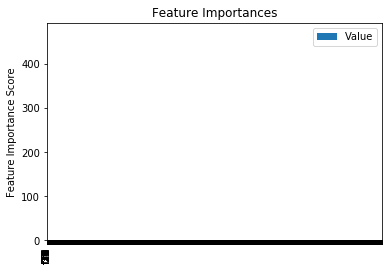

In [0]:
#Predict training set:
dtrain_predictions = lgbm.predict(X_train_re)
    
#Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(y_train_re.values, dtrain_predictions))
print("Test Accuracy : %.4g" % metrics.accuracy_score(y_test_response.values, lgbm.predict(X_test_resp_le)))
                
feat_imp = pd.DataFrame({'Value':lgbm.feature_importances_,'Feature':['f'+str(i) for i in range(35)]}).\
            sort_values(ascending=False,by='Value')
feat_imp.plot(kind='bar', title='Feature Importances')
plt.xticks(np.arange(len(X_train_re)),feat_imp['Feature'])
plt.ylabel('Feature Importance Score')

## LightGBM with label encoding

In [0]:
lgbm2 = LGBMClassifier(learning_rate=0.1,boosting_type='gbdt',objective='multiclass',metric='multi_logloss',num_class=4,sub_feature=0.5,num_leaves=10,\
                     min_data=2000,max_depth=10)
lgbm2.fit(X_train_le,y_train_le)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=10,
               metric='multi_logloss', min_child_samples=20,
               min_child_weight=0.001, min_data=2000, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_class=4, num_leaves=10,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, sub_feature=0.5, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [0]:
predict_y = lgbm2.predict(X_train_le)
print ("The train f1 score is:",f1_score(y_train_le, predict_y,average='weighted'))
predict_y = lgbm2.predict(X_test)
print("The test f1 score is:",f1_score(y_test, predict_y,average='weighted'))

The train f1 score is: 0.7329490593111434
The test f1 score is: 0.7664431489370538



Model Report
Accuracy : 0.7418
Test Accuracy : 0.7708


Text(0, 0.5, 'Feature Importance Score')

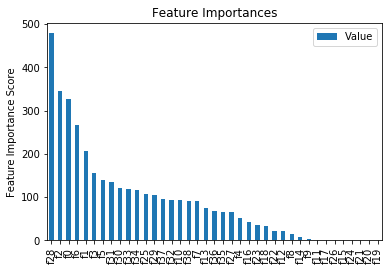

In [0]:
#Predict training set:
dtrain_predictions = lgbm2.predict(X_train_le)
    
#Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(y_train_le.values, dtrain_predictions))
print("Test Accuracy : %.4g" % metrics.accuracy_score(y_test.values, lgbm2.predict(X_test)))
                
feat_imp = pd.DataFrame({'Value':lgbm2.feature_importances_,'Feature':['f'+str(i) for i in range(39)]}).\
            sort_values(ascending=False,by='Value')
feat_imp.plot(kind='bar', title='Feature Importances')
plt.xticks(np.arange(len(X_train.columns)),feat_imp['Feature'])
plt.ylabel('Feature Importance Score')0.752 0.7708

## XGBoost with response coding

In [0]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [0]:
x_cfl=XGBClassifier(objective= 'multi:softmax',num_class=4,n_jobs = -1)
prams={
'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
'n_estimators':[100,200,500,1000,2000],
'max_depth':[3,5,10],
'colsample_bytree':[0.1,0.3,0.5,1],
'subsample':[0.1,0.3,0.5,1],
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams)
random_cfl.fit(X_train_re, y_train_re)

In [0]:
random_cfl.best_params_

In [0]:
# Training with best parameters
x_cfl=XGBClassifier(objective= 'multi:softmax',num_class=4,n_fold=4,
                    colsample_bytree = 1,
                    learning_rate = 0.15,
                    max_depth = 5,
                    n_estimators = 500,
                    subsample = 0.3)
x_cfl.fit(X_train_re, y_train_re)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.15, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_fold=4, n_jobs=0, num_class=4,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.3,
              tree_method=None, validate_parameters=False, verbosity=None)


Model Report
Accuracy : 0.8314


Text(0, 0.5, 'Feature Importance Score')

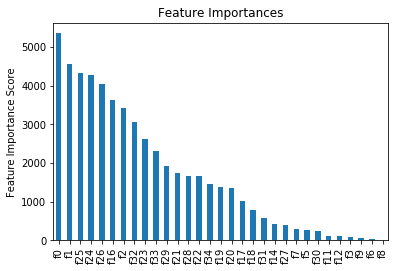

In [0]:
#Predict training set:
dtrain_predictions = x_cfl.predict(X_train_re)
    
#Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(y_train_re, dtrain_predictions))
                
feat_imp = pd.Series(x_cfl.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8104


Text(0, 0.5, 'Feature Importance Score')

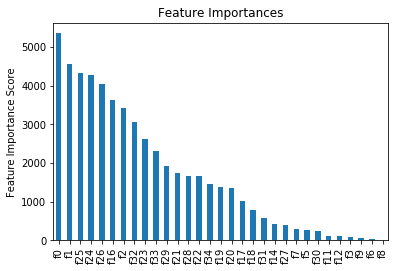

In [0]:
#Predict testing set:
dtest_predictions = x_cfl.predict(X_test_resp_le)
    
#Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(y_test_response, dtest_predictions))
                
feat_imp = pd.Series(x_cfl.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [0]:
predict_y = x_cfl.predict(X_train_re)
print ("The train f1 score is:",f1_score(y_train_re, predict_y,average='weighted'))
predict_y = x_cfl.predict(X_test_resp_le)
print("The test f1 score is:",f1_score(y_test_response, predict_y,average='weighted'))

The train f1 score is: 0.8300635043829951
The test f1 score is: 0.8146838840515627


## XGBoost with label encoding

In [0]:
# Training with best parameters
x_cfl2=XGBClassifier(objective= 'multi:softmax',num_class=4,n_fold=4,
                    colsample_bytree = 1,
                    learning_rate = 0.15,
                    max_depth = 5,
                    n_estimators = 600,
                    subsample = 0.3)
x_cfl2.fit(X_train_le, y_train_le)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.15, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=600, n_fold=4, n_jobs=0, num_class=4,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.3,
              tree_method=None, validate_parameters=False, verbosity=None)

In [0]:
#Doing this to change the feature names as sampling changed the column names and there is a feature mismatch if I run this directly
new_feat = []
for i in range(39):
    new_feat.append('f'+str(i))
len(new_feat)

39

In [0]:
f = {}
for old,new in zip(X_test.columns,new_feat):
    f[old] = new
X_test_new = X_test.rename(columns=f)

In [0]:
predict_y = x_cfl2.predict(X_train_le)
print ("The train f1 score is:",f1_score(y_train_le, predict_y,average='weighted'))
predict_y = x_cfl2.predict(X_test_new)
print("The test f1 score is:",f1_score(y_test, predict_y,average='weighted'))

The train f1 score is: 0.8383417093995029
The test f1 score is: 0.8276016544404952



Model Report
Accuracy : 0.8395


Text(0, 0.5, 'Feature Importance Score')

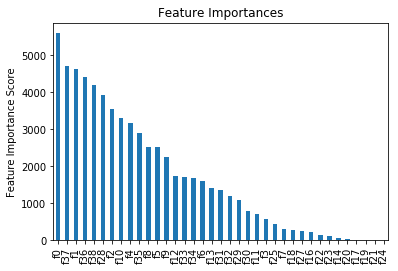

In [0]:
#Predict training set:
dtrain_predictions = x_cfl2.predict(X_train_le)
    
#Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(y_train_le, dtrain_predictions))
                
feat_imp = pd.Series(x_cfl2.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

## Model 4: Random Forest With response coding

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 400, stop = 1500, num = 5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [0]:
# Use the random grid to search for best hyperparameters
rf = RandomForestClassifier(n_jobs = -1,bootstrap=True,max_features='auto',class_weight='balanced')
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(X_train_re, y_train_re)

In [0]:
best = rf_random.best_params_

In [0]:
# training the model with same params as above XGBoost model as hyperparmater tuning is taking too long due to lack of computing power
rf = RandomForestClassifier(n_jobs = -1,bootstrap=True,max_features='auto',
                            n_estimators=800,max_depth=20,
                            class_weight='balanced')
rf.fit(X_train_re, y_train_re)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [0]:
#Print model report:
print("\nModel Report")
print("Train Accuracy : %.4g" % metrics.accuracy_score(y_train_re, rf.predict(X_train_re)))
print("Test Accuracy : %.4g" % metrics.accuracy_score(y_test_response, rf.predict(X_test_resp_le)))


Model Report
Train Accuracy : 0.8637
Test Accuracy : 0.7275


In [0]:
predict_y = rf.predict(X_train_re)
print ("The train f1 score is:",f1_score(y_train_re, predict_y,average='weighted'))
predict_y = rf.predict(X_test_resp_le)
print("The test f1 score is:",f1_score(y_test_response, predict_y,average='weighted'))

The train f1 score is: 0.8669344126262463
The test f1 score is: 0.7468366336877629


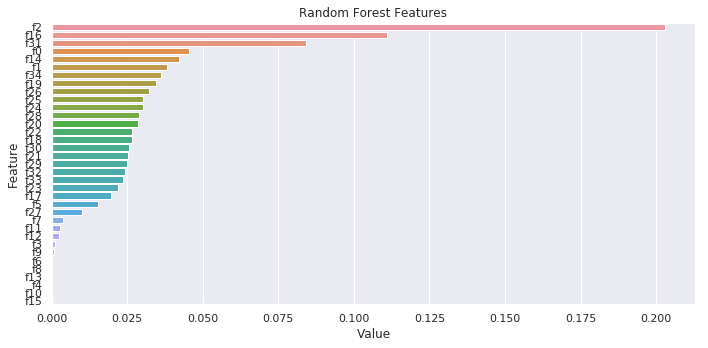

In [0]:
feature_imp = pd.DataFrame({'Value':rf.feature_importances_,'Feature':['f'+str(i) for i in range(35)]})
plt.figure(figsize=(10, 5))
sns.set(font_scale = 1)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                    ascending=False)[0:len(rf.feature_importances_)])
plt.title('Random Forest Features')
plt.tight_layout()
plt.show()

## Random Forest with label encoding

In [0]:
# training the model with same params as above XGBoost model as hyperparmater tuning is taking too long due to lack of computing power
rf2 = RandomForestClassifier(n_jobs = -1,bootstrap=True,max_features='auto',
                            n_estimators=500,max_depth=20,
                            class_weight='balanced')
rf2.fit(X_train_le, y_train_le)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [0]:
predict_y = rf2.predict(X_train_le)
print ("The train f1 score is:",f1_score(y_train_le, predict_y,average='weighted'))
predict_y = rf2.predict(X_test)
print("The test f1 score is:",f1_score(y_test, predict_y,average='weighted'))

The train f1 score is: 0.8705869027916473
The test f1 score is: 0.7677082889233752


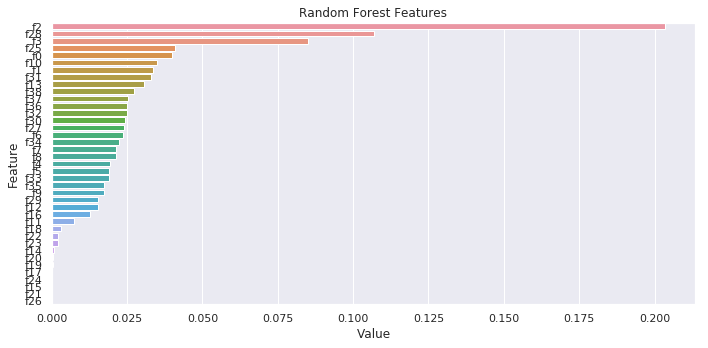

In [0]:
feature_imp = pd.DataFrame({'Value':rf2.feature_importances_,'Feature':['f'+str(i) for i in range(39)]})
plt.figure(figsize=(10, 5))
sns.set(font_scale = 1)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                    ascending=False)[0:len(rf2.feature_importances_)])
plt.title('Random Forest Features')
plt.tight_layout()
plt.show()

## Random forest without resampling data

In [0]:
# training the model with same params as above XGBoost model as hyperparmater tuning is taking too long due to lack of computing power
rf3 = RandomForestClassifier(n_jobs = -1,bootstrap=True,max_features='auto',
                            n_estimators=800,max_depth=15,
                            class_weight='balanced')
rf3.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [0]:
predict_y = rf3.predict(X_train)
print ("The train f1 score is:",f1_score(y_train, predict_y,average='weighted'))
predict_y = rf3.predict(X_test)
print("The test f1 score is:",f1_score(y_test, predict_y,average='weighted'))

The train f1 score is: 0.7410160850576536
The test f1 score is: 0.7195180828093957


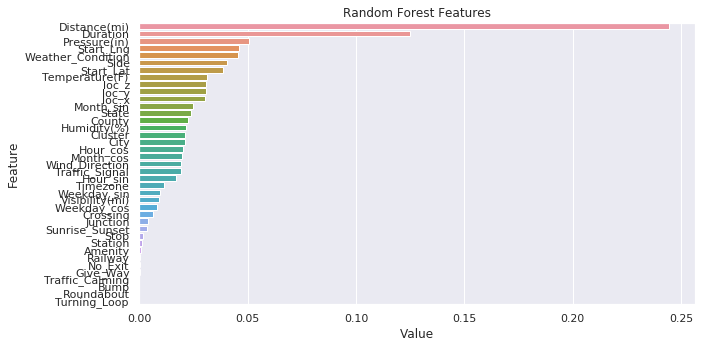

In [0]:
feature_imp = pd.DataFrame({'Value':rf3.feature_importances_,'Feature':X_train.columns})
plt.figure(figsize=(10, 5))
sns.set(font_scale = 1)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                    ascending=False)[0:len(rf3.feature_importances_)])
plt.title('Random Forest Features')
plt.tight_layout()
plt.show()

## XGBoost without resampling

In [0]:
# Training with best parameters
x_cfl3=XGBClassifier(objective= 'multi:softmax',num_class=4,n_fold=4,
                    colsample_bytree = 1,
                    learning_rate = 0.15,
                    max_depth = 8,
                    n_estimators = 800,
                    subsample = 0.3)
x_cfl3.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.15, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=800, n_fold=4, n_jobs=0, num_class=4,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.3,
              tree_method=None, validate_parameters=False, verbosity=None)

In [0]:
predict_y = x_cfl3.predict(X_train)
print ("The train f1 score is:",f1_score(y_train, predict_y,average='weighted'))
predict_y = x_cfl3.predict(X_test)
print("The test f1 score is:",f1_score(y_test, predict_y,average='weighted'))

The train f1 score is: 0.9209503140767868
The test f1 score is: 0.8567448674111096



Model Report
Accuracy : 0.9218


Text(0, 0.5, 'Feature Importance Score')

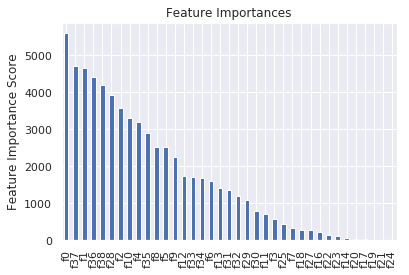

In [0]:
#Predict training set:
dtrain_predictions = x_cfl3.predict(X_train)
    
#Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
                
feat_imp = pd.Series(x_cfl2.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

## Trying the best model with full dataset and resampling


In [0]:
# summarize class distribution
counter = Counter(y_train)
print(counter)

under = RandomUnderSampler(sampling_strategy={3: 500000,2: 1000000})
over = SMOTE(sampling_strategy={1: 50000,4:100000})
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_le, y_train_le = pipeline.fit_resample(np.array(X_train), y_train)
# summarize the new class distribution
counter = Counter(y_train_le)
print(counter)

Counter({2.0: 1395367, 3.0: 621326, 4.0: 64631, 1.0: 678})
Counter({2.0: 1000000, 3.0: 500000, 4.0: 100000, 1.0: 50000})


In [0]:
# Training with best parameters
x_cfl4=XGBClassifier(objective= 'multi:softmax',num_class=4,n_fold=4,
                    colsample_bytree = 1,
                    learning_rate = 0.15,
                    max_depth = 8,
                    n_estimators = 1000,
                    subsample = 0.3,tree_method='gpu_hist')
x_cfl4.fit(X_train_le, y_train_le)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=1000, n_fold=4,
              n_jobs=1, nthread=None, num_class=4, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.3, tree_method='gpu_hist',
              verbosity=1)

In [0]:
#Doing this to change the feature names as sampling changed the column names and there is a feature mismatch if I run this directly
new_feat = []
for i in range(40):
    new_feat.append('f'+str(i))
f = {}
for old,new in zip(X_test.columns,new_feat):
    f[old] = new
X_test_new = X_test.rename(columns=f)

In [0]:
predict_y = x_cfl4.predict(X_train_le)
print ("The train f1 score is:",f1_score(y_train_le, predict_y,average='weighted'))
predict_y = x_cfl4.predict(X_test_new)
print("The test f1 score is:",f1_score(y_test, predict_y,average='weighted'))

The train f1 score is: 0.9095121662196698
The test f1 score is: 0.8664525252175098


In [2]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Categorical_encoding","Test Score"]
x.add_row(["Linear Regression",'Label',0.7203])
x.add_row(["Linear Regression",'Response',0.7206])
x.add_row(["LightGBM",'Label',0.7708])
x.add_row(["LightGBM",'Response',0.752])
x.add_row(["XGBoost",'Label',0.827])
x.add_row(["XGBoost",'Response',0.814])
x.add_row(["XGBoost without respampling",'Response',0.856])
x.add_row(["Random Forest",'Label',0.767])
x.add_row(["Random Forest",'Response',0.746])
x.add_row(["Random Forest without resampling",'Response',0.719])
x.add_row(["XGBoost with full dataset and resampling",'Response',0.866])
print(x)

+------------------------------------------+----------------------+------------+
|                  Model                   | Categorical_encoding | Test Score |
+------------------------------------------+----------------------+------------+
|            Linear Regression             |        Label         |   0.7203   |
|            Linear Regression             |       Response       |   0.7206   |
|                 LightGBM                 |        Label         |   0.7708   |
|                 LightGBM                 |       Response       |   0.752    |
|                 XGBoost                  |        Label         |   0.827    |
|                 XGBoost                  |       Response       |   0.814    |
|       XGBoost without respampling        |       Response       |   0.856    |
|              Random Forest               |        Label         |   0.767    |
|              Random Forest               |       Response       |   0.746    |
|     Random Forest without 

# Observations:

1. This dataset is very huge and due to this I tried to drop as many features as I can without losing any meaningful information.
2. I experimented with various models such as Logistic Regression, Random Forest, Decision Trees, LightGBM and stacking classifiers but XGBoost gave the best results out of these, so that is the model I have used.
3. The categorical features were of very high cardinality, as a result I was not able to use some other encoding techniques such as one hot encoding and response coding. This is why I have used label encoder as it is easier on the memory.
4. I have also used the formulae sin(2*pi*x/max(x)) and cos(2*pi*x/max(x)) to encode cyclic features to preserve the order of variables which are cyclical.
5. I used value count as feature for some columns in which I thought the number of occurences directly influences the target variable.
6. Some new features have also been created which include 'Duration' which is the difference between start and end time of the accidents, also, I used the latitude and longitude to form clusters and assign a cluster number to each data point which is then been added as a feature.
7. The latitude and longitude may not have been too useful by themselves, so I used sin and cos to get 3 dimensional representation of those points and added them as seperate features.
8. The dataset contained 4 accident severities and the number of data points was very disproportionate in all classes as the accidents in the highest severity hardly ever occur and make up for hardly any fraction of the data, so I have tried to rectify this by oversampling these and undersampling the dominating classes to get the ratio to be a little better but this did not have much of an impact on the results.
9. We can see some models over and underfit but that is because I was not using all the datapoints to train and just wanted to see the models' performance relative to each other and get a general idea of how models would work on the dataset.
10. I used the full dataset for the best model along with sampling, there is slight overfitting but that is because I resampled the training data and the test data doesn't have that many points from the minority classes but I still kept the sampling part because this data will work better when there is more data from minority classes in any future dataset and relative performance drop from non sampled data to this is very minimal.